In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import talib as tl
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
from utils import read_ami_SPY_data

In [4]:
train_size = 150
test_size = 5
full_size = train_size + test_size
return_day = 10

In [5]:
data = read_ami_SPY_data()

In [6]:
oopen = data['Open'].values
high = data['High'].values
low = data['Low'].values
close = data['Close'].values

In [7]:
features_to_delete = data.columns.tolist()

# ROC

In [8]:
for i in [5, 10, 20, 30]:
    data[f'ROC {i}'] = tl.ROC(close, timeperiod=i)

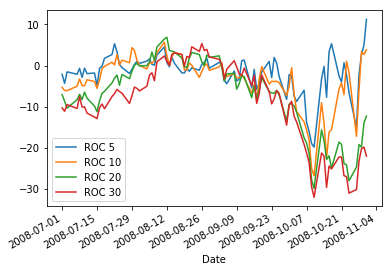

In [9]:
data['2008-07': '2008-10'][['ROC 5', 'ROC 10', 'ROC 20', 'ROC 30']].plot()

# Deviation from zero-lag exponential MA

In [10]:
for i in [10, 20, 40]:
    lag = (i-1)/2
    ema_data = 2*data['Close'] - data['Close'].shift(i).fillna(method='bfill')
    data['Deviation EMA ' + str(i)] = data['Close'] - tl.EMA(ema_data.values, timeperiod=i)

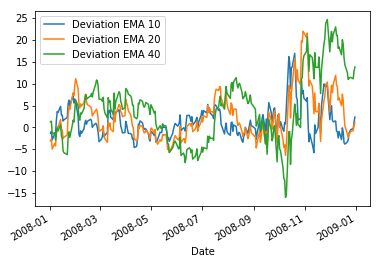

In [11]:
data['2008'][['Deviation EMA 10', 'Deviation EMA 20', 'Deviation EMA 40']].plot()

# MACD

In [12]:
for i, j, k in [(14, 20, 12), (12, 16, 9), (3, 5, 2)]:
    macd, macdsignal, macdhist = tl.MACD(close, fastperiod=i, slowperiod=j, signalperiod=k)
    data[f'MACD ({i}, {j}, {k})'] = macd
#     data[f'MACD signal ({i}, {j}, {k})'] = macdsignal
#     data[f'MACD hist ({i}, {j}, {k})'] = macdhist

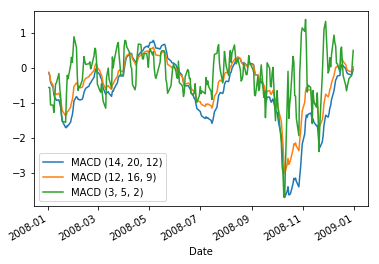

In [13]:
data['2008'][['MACD (14, 20, 12)', 'MACD (12, 16, 9)', 'MACD (3, 5, 2)']].plot()

In [14]:
# data['2008'][['MACD signal (12, 16, 9)', 'MACD signal (3, 5, 2)']].plot()

In [15]:
# data['2008'][['MACD hist (14, 20, 12)', 'MACD hist (12, 16, 9)', 'MACD hist (3, 5, 2)']].plot()

# RSI

In [16]:
for i in [5, 10, 14, 20]:
    data[f'RSI {i}'] = tl.RSI(close, timeperiod=i)

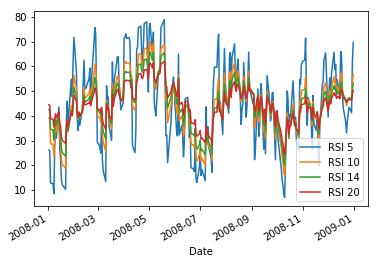

In [17]:
data['2008'][['RSI 5', 'RSI 10', 'RSI 14', 'RSI 20']].plot()

# SMA differences

In [18]:
for i, j in [(5, 10), (10, 20), (20, 40)]:
    data[f'SMA ({i}, {j}) diff'] = tl.SMA(close, timeperiod=i) - tl.SMA(close, timeperiod=j)

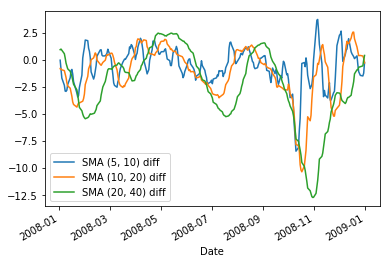

In [19]:
data['2008'][['SMA (5, 10) diff', 'SMA (10, 20) diff', 'SMA (20, 40) diff']].plot()

# ADX

In [20]:
data['ADX 20'] = tl.ADX(high, low, close, timeperiod=20)
data['ADX 14'] = tl.ADX(high, low, close, timeperiod=14)
data['ADX 7'] = tl.ADX(high, low, close, timeperiod=7)

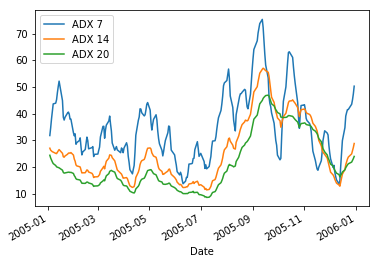

In [21]:
data['2005'][['ADX 7', 'ADX 14', 'ADX 20']].plot()

# CCI

In [22]:
data['CCI 14'] = tl.CCI(high, low, close, timeperiod=14)

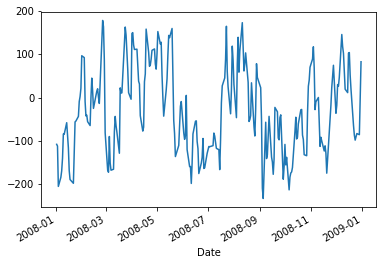

In [23]:
data['2008']['CCI 14'].plot()

# STD deviation 20

In [24]:
data['Std dev 10'] = tl.STDDEV(close, timeperiod=10)
data['Std dev 20'] = tl.STDDEV(close, timeperiod=20)

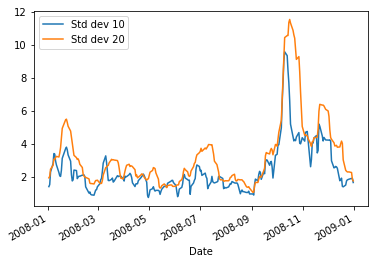

In [25]:
data['2008'][['Std dev 10', 'Std dev 20']].plot()

# Y target value

In [26]:
data['Return'] = data['Close'].pct_change(return_day).shift(-return_day)*100
data['Extreme'] = data['Close'].pct_change(return_day).rolling(return_day).std()*100

In [27]:
data.dropna(inplace=True)
data.drop(columns=features_to_delete, inplace=True)
data.head()

,ROC 5,ROC 10,ROC 20,ROC 30,Deviation EMA 10,Deviation EMA 20,Deviation EMA 40,"MACD (14, 20, 12)","MACD (12, 16, 9)","MACD (3, 5, 2)",...,"SMA (10, 20) diff","SMA (20, 40) diff",ADX 20,ADX 14,ADX 7,CCI 14,Std dev 10,Std dev 20,Return,Extreme
Date,,,,,,,,,,,,,,,,,,,,,
1999-05-05,-0.415512,-0.046339,1.243877,6.835067,-1.793634,-2.853139,-0.432770,0.403900,0.239577,-0.059121,...,0.93594,2.150785,20.440722,20.489020,27.166137,-11.558144,1.199364,1.942356,0.069504,1.336039
1999-05-06,-0.267523,-1.595153,-0.637330,5.577426,-1.750246,-3.248888,-1.433450,0.351419,0.192688,-0.138730,...,0.76172,1.987895,19.525417,19.845702,28.433563,-22.992688,1.221660,1.940844,0.081651,1.642920
1999-05-07,1.313321,-0.598251,0.092678,4.247104,-0.453265,-2.032408,-0.610786,0.344498,0.190961,0.027138,...,0.67422,1.884770,18.655876,19.248335,29.519928,-3.573762,1.197413,1.942808,-1.226889,1.732266
1999-05-10,-1.001861,-1.658642,-1.455773,4.484667,-0.508662,-2.257764,-1.461731,0.309100,0.161892,-0.034079,...,0.54688,1.661723,17.785037,18.298311,28.103513,-26.438913,1.084316,1.888977,-2.384535,1.921237
1999-05-11,1.448598,-1.138434,0.184587,3.454888,0.980149,-0.836615,-0.315329,0.329205,0.186469,0.177762,...,0.37813,1.562503,17.270934,17.280123,24.967837,55.896787,0.789305,1.897725,-4.928604,2.008456


### Features

In [28]:
feature_names = data.drop(['Return', 'Extreme'], axis=1).columns

# Train and test Random Forest

In [29]:
def to_class(y_vec, extreme):
#     y_extreme = extreme_multiplier * y_vec.rolling(test_size).std().shift(return_day).fillna(method='ffill').fillna(method='bfill')
    
    pos = y_vec > extreme
    neg = y_vec < -1*extreme

    y_vec[:] = 'Neutral'
    y_vec[pos] = 'Pos'
    y_vec[neg] = 'Neg'
    return y_vec

In [30]:
def make_X_y(df):
    X = df.drop(['Return', 'Extreme'], axis=1)
    y = df['Return'].copy()
    ret = y.copy()
    y = to_class(y, 3) # df['Extreme']
    return X, y, ret

In [31]:
def split_X_y(X, y, ret):
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]
    ret = ret.iloc[train_size:]
    
    last_q4 = int(train_size/4)
    last_q8 = int(train_size/8)
    last_q16 = int(train_size/16)
    X_train = pd.concat([X_train, X_train[-last_q4:], X_train[-last_q8:], X_train[-last_q16:]], ignore_index=True)
    y_train = pd.concat([y_train, y_train[-last_q4:], y_train[-last_q8:], y_train[-last_q16:]], ignore_index=True)
    return X_train, X_test, y_train, y_test, ret

In [32]:
def print_labels_distrib(y_train, y_test):
    def distrib_print(vec):
        print('---\nDistribution:\n' + str(vec.value_counts()))
        
    distrib_print(y_train)
    distrib_print(y_test)

In [33]:
from sklearn.metrics import make_scorer
def custom_loss(y_true, y_pred):
    bad_sum     = -8*np.sum(((y_true == 'Pos') & (y_pred == 'Neg')) | ((y_true == 'Neg') & (y_pred == 'Pos')))
    np_sum      = -2*np.sum(((y_true == 'Neutral') & (y_pred == 'Pos')) | ((y_true == 'Neutral') & (y_pred == 'Neg')))
    pn_sum      = -1*np.sum(((y_true == 'Pos') & (y_pred == 'Neutral')) | ((y_true == 'Neg') & (y_pred == 'Neutral')))
    good_sum    =  8*np.sum(((y_true == 'Pos') & (y_pred == 'Pos')) | ((y_true == 'Neg') & (y_pred == 'Neg')))
    return bad_sum + np_sum + pn_sum + good_sum
scorer = make_scorer(custom_loss, greater_is_better=True)

In [34]:
def calculate_returns(ret, y_pred):
    longs = np.nansum(ret[y_pred == 'Pos'])
    shorts = np.nansum(-1*ret[y_pred == 'Neg'])
    ret_sum = longs + shorts
    print(f'{longs} [long] + {shorts} [short] = {ret_sum}')
    return ret_sum

In [35]:
def print_results(y_test, y_pred):
    print('---\nClassification report\n', classification_report(y_test, y_pred))
    print('---\nConfusion matrix\n', str(confusion_matrix(y_test, y_pred)))

## Train and Test

In [36]:
def train_and_test(df):
    X, y, ret = make_X_y(df)
    X_train, X_test, y_train, y_test, ret = split_X_y(X, y, ret)
    print_labels_distrib(y_train, y_test)
    
    forest = RandomForestClassifier(n_jobs=8, class_weight='balanced_subsample')
    pipe = Pipeline(steps=[('scaler', StandardScaler()), 
#                            ('pca', PCA()), 
                           ('forest', forest)])
    
    params = {'forest__n_estimators': [100],
              'forest__max_depth': [None],
              'forest__max_features': [2,3,5],
              'forest__min_samples_split': [2,3,5],
              'forest__min_samples_leaf': [2,3],
#               'pca__n_components': [0.3, 0.7]
             }
    grid = GridSearchCV(estimator=pipe,
                        param_grid=params, 
                        scoring=scorer,
                        cv=3)
    
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_estimator.predict(X_test)
    print_results(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    ret_sum = calculate_returns(ret, y_pred)
    
    param = {
        'accuracy':acc,
        'date': df.index[-1],
        'best_params': best_params,
        'features': best_estimator.steps[-1][1].feature_importances_,
        'ret_sum': ret_sum
    }
    test_params.append(param)

In [37]:
test_params = []

for i in range(0, len(data)-full_size, test_size):
    sub_data = data.iloc[i:i+full_size]
    from_date, to_date = sub_data.index[0], sub_data.index[-1]
    sep = 100*'='
    print(f'{sep}\nFrom {from_date} to {to_date}')
    train_and_test(sub_data)

From 1999-05-05 00:00:00 to 1999-12-13 00:00:00
---
Distribution:
Neutral    131
Pos         53
Neg         30
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-05-12 00:00:00 to 1999-12-20 00:00:00
---
Distribution:
Neutral    130
Pos         55
Neg         29
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         3

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [2 0 0]
 [0 3 0]]
0.0 [long] + -0.5816362941389763 [short] = -0.5816362941389763
From 1999-05-19 00:00:00 to 1999-12-28 00:00:00
---
Distribution:
Neutral    127
Pos         62
Neg         25
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-05-26 00:00:00 to 2000-01-04 00:00:00
---
Distribution:
Neutral    130
Pos         56
Neg         28
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-06-03 00:00:00 to 2000-01-11 00:00:00
---
Distribution:
Neutral    133
Pos         53
Neg         28
Name: Return, dtype: int64
---
Distribution:
Neutral    2
Pos        2
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.00      0.00      0.00         2
        Pos       0.67      1.00      0.80         2

avg / total       0.27      0.40      0.32         5

---
Confusion matrix
 [[0 1 0]
 [1 0 1]
 [0 0 2]]
5.298948631525768 [long] + 2.5519031141868487 [short] = 7.850851745712617
From 1999-06-10 00:00:00 to 2000-01-19 00:00:00
-

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -1.0975153060345244 [short] = -1.0975153060345244
From 1999-06-24 00:00:00 to 2000-02-02 00:00:00
---
Distribution:
Neutral    121
Pos         48
Neg         45
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.80      0.89         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[4 1]
 [0 0]]
2.0699172033118662 [long] + 0.0 [short] = 2.0699172033118662
From 1999-07-01 00:00:00 to 2000-02-09 00:00:00
---
Distribution:
Neutral    133
Neg         41
Pos         40
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-07-09 00:00:00 to 2000-02-16 00:00:00
---
Distribution:
Neutral    119
Neg         59
Pos         36
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         1
    Neutral       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[1 0]
 [0 4]]
0.0 [long] + 5.816794701986749 [short] = 5.816794701986749
From 1999-07-16 00:00:00 to 2000-02-24 00:00:00
---
Distribution:
Neutral    123
Neg         55
Pos         36
Name: Return, dtype: int64
---
D

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-08-06 00:00:00 to 2000-03-16 00:00:00
---
Distribution:
Neutral    117
Pos         66
Neg         31
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neutral    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         1
        Pos       0.00      0.00      0.00         4

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 1]
 [4 0]]
1.6015721893050339 [long] + 0.0 [short] = 1.6015721893050339
From 1999-08-13 00:00:00 to 2000-03-23 00:00:00
---
Distribution:
Neutral    110
Pos         75
Neg         29
Name: Return, dtype: int64
---

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-08-27 00:00:00 to 2000-04-06 00:00:00
---
Distribution:
Neutral    118
Pos         66
Neg         30
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-09-03 00:00:00 to 2000-04-13 00:00:00
---
Distribution:
Neutral    107
Pos         60
Neg         47
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.75      0.75      0.75         4
        Pos       0.00      0.00      0.00         0

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[0 1 0]
 [0 3 1]
 [0 0 0]]
0.5848873483535577 [long] + 0.0 [short] = 0.5848873483535577
From 1999-09-13 00:00:00 to 2000-04-20 00:00:00
---
Distribution:
Neutral    113
Pos         56
Neg         45
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         4
        Pos       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[4 0]
 [0 1]]
8.134191176470583 [long] + 0.0 [short] = 8.134191176470583
From 1999-09-20 00:00:00 to 2000-04-28 00:00:00

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.75      0.75      0.75         4
        Pos       0.00      0.00      0.00         1

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[0 0 0]
 [1 3 0]
 [0 1 0]]
0.0 [long] + 1.2112537186570238 [short] = 1.2112537186570238
From 1999-10-04 00:00:00 to 2000-05-12 00:00:00
---
Distribution:
Neutral    124
Pos         49
Neg         41
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       1.00      0.50      0.67         4
        Pos       0.00      0.00      0.00         0

avg / total       0.80      0.40      0.53         5

---
Confusion matrix
 [[0 0 1]
 [0 2 2]
 [0 0 0]]
-4.175437057945819 [long] + 0.0 [short] = -4.175437057945819
From 1999-10-11 00:00:00 to 2000-05-19 00:00:00
---
Distribution:
Neutral    128
Pos         46
Neg         40
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         3
        Pos       0.25      0.50      0.33         2

avg / total       0.10      0.20      0.13         5

---
Confusion matrix
 [[0 3]
 [1 1]]
-1.3315579120285914 [long] + 0.0 [short] = -1.3315579120285914
From 1999-10-18 00:00:00 to 2000-05-26 00:0

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       1.00      0.60      0.75         5

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[0 0]
 [2 3]]
17.79426566925857 [long] + 0.0 [short] = 17.79426566925857
From 1999-10-25 00:00:00 to 2000-06-05 00:00:00
---
Distribution:
Neutral    117
Pos         66
Neg         31
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.50      0.67      0.57         3
        Pos       0.00      0.00      0.00         2

avg / total       0.30      0.40      0.34         5

---
Confusion matrix
 [[2 1]
 [2 0]]
0.9133050127442699 [long] + 0.0 [short] = 0.9133050127442699
From 1999-11-01 00:00:00 to 2000-06-12 00:00:00
---
Distribution:
Neutral    119
Pos         67
Neg         28
Na

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.40      0.57         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
-2.1207145368272617 [long] + 0.0 [short] = -2.1207145368272617
From 1999-11-08 00:00:00 to 2000-06-19 00:00:00
---
Distribution:
Neutral    131
Pos         56
Neg         27
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-11-15 00:00:00 to 2000-06-26 00:00:00
---
Distribution:
Neutral    141
Pos         48
Neg         25
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-11-30 00:00:00 to 2000-07-11 00:00:00
---
Distribution:
Neutral    140
Pos         50
Neg         24
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.75      0.75      0.75         4
        Pos       0.00      0.00      0.00         1

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[3 1]
 [1 0]]
2.7225583405358744 [long] + 0.0 [short] = 2.7225583405358744
From 1999-12-07 00:00:00 to 2000-07-18 00:00:00
---
Distribution:
Neutral    137
Pos         54
Neg         23
Name: Return, dtype: int64
---

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-12-14 00:00:00 to 2000-07-25 00:00:00
---
Distribution:
Neutral    134
Pos         45
Neg         35
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-12-21 00:00:00 to 2000-08-01 00:00:00
---
Distribution:
Neutral    138
Neg         39
Pos         37
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.67      1.00      0.80         2
        Pos       1.00      0.67      0.80         3

avg / total       0.87      0.80      0.80         5

---
Confusion matrix
 [[2 0]
 [1 2]]
8.13117770023033 [long] + 0.0 [short] = 8.13117770023033
From 1999-12-29 00:00:00 to 2000-08-08 00:00:00
---
Distribution:
Neutral    133
Pos         46
Neg         35
Name: Return, dtype: int64
---
Dis

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.50      0.25      0.33         4
        Pos       0.00      0.00      0.00         1

avg / total       0.40      0.20      0.27         5

---
Confusion matrix
 [[0 0 0]
 [3 1 0]
 [0 1 0]]
0.0 [long] + -4.917260291241621 [short] = -4.917260291241621
From 2000-01-05 00:00:00 to 2000-08-15 00:00:00
---
Distribution:
Neutral    131
Pos         49
Neg         34
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         4
        Pos       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[4 0]
 [0 1]]
3.131025561158851 [long] + 0.0 [short] = 3.131025561158851
From 2000-01-12 00:00:00 to 2000-08-22 00:00:00

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-02-03 00:00:00 to 2000-09-13 00:00:00
---
Distribution:
Neutral    136
Neg         40
Pos         38
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-02-10 00:00:00 to 2000-09-20 00:00:00
---
Distribution:
Neutral    124
Neg         52
Pos         38
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         1
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         0

avg / total       0.20      0.20      0.20         5

---
Confusion matrix
 [[1 0 0]
 [0 0 4]
 [0 0 0]]
-5.395070898247278 [long] + 3.1011637216103116 [short] = -2.2939071766369663
From 2000-02-17 00:00:00 to 2000-09-27 00:00:00
---
Distribution:
Neutral    127
Neg         50
Pos         37
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.67      0.67      0.67         3
        Pos       0.00      0.00      0.00         0

avg / total       0.40      0.40      0.40         5

---
Confusion matrix
 [[0 1 1]
 [0 2 1]
 [0 0 0]]
-2.262301193086702 [long] + 0.0 [short] = -2.262301193086702
From 2000-02-25 00:00:00 to 2000-10-04 00:00:00
---
Distribution:
Neutral    130
Neg         52
Pos         32
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 4 1]
 [0 0 0]
 [0 0 0]]
-6.568073075250114 [long] + 0.0 [short] = -6.568073075250114
From 2000-03-03 00:00:00 to 2000-10-11 00:00:00
---
Distribution:
Neutral    118
Neg         67
Pos         29
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      1.00      0.67         1
    Neutral       1.00      0.75      0.86         4

avg / total       0.90      0.80      0.82         5

---
Confusion matrix
 [[1 0]
 [1 3]]
0.0 [long] + 4.20072188072016 [short] = 4.20072188072016
From 2000-03-10 00:00:00 to 2000-10-18 00:00:00
-

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-03-17 00:00:00 to 2000-10-25 00:00:00
---
Distribution:
Neutral    127
Neg         59
Pos         28
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.75      0.75      0.75         4
        Pos       0.00      0.00      0.00         1

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[3 1]
 [1 0]]
2.4338088829071403 [long] + 0.0 [short] = 2.4338088829071403
From 2000-03-24 00:00:00 to 2000-11-01 00:00:00
---
Distribution:
Neutral    130
Neg         53
Pos         31
Name: Return, dtype: int64
---

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.75      0.75      0.75         4
        Pos       0.00      0.00      0.00         0

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[0 1 0]
 [0 3 1]
 [0 0 0]]
2.446236854138095 [long] + 0.0 [short] = 2.446236854138095
From 2000-03-31 00:00:00 to 2000-11-08 00:00:00
---
Distribution:
Neutral    138
Neg         47
Pos         29
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-04-07 00:00:00 to 2000-11-15 00:00:00
---
Distribution:
Neutral    127
Neg         59
Pos         28
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.25      0.50      0.33         2
        Pos       0.00      0.00      0.00         0

avg / total       0.10      0.20      0.13         5

---
Confusion matrix
 [[0 3 0]
 [0 1 1]
 [0 0 0]]
-1.3831258644536604 [long] + 0.0 [short] = -1.3831258644536604
From 2000-04-14 00:00:00 to 2000-11-22 00:00:00
---
Distribution:
Neutral    120
Neg         68
Pos         26
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.67      0.50      0.57         4
        Pos       0.00      0.00      0.00         0

avg / total       0.53      0.40      0.46         5

---
Confusion matrix
 [[0 1 0]
 [0 2 2]
 [0 0 0]]
-0.16228313265779226 [long] + 0.0 [short] = -0.16228313265779226
From 2000-04-24 00:00:00 to 2000-11-30 00:00:00
---
Distribution:
Neutral    128
Neg         62
Pos         24
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-05-01 00:00:00 to 2000-12-07 00:00:00
---
Distribution:
Neutral    136
Neg         50
Pos         28
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-05-08 00:00:00 to 2000-12-14 00:00:00
---
Distribution:
Neutral    129
Neg         58
Pos         27
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         2
    Neutral       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + 14.386063447897515 [short] = 14.386063447897515
From 2000-05-15 00:00:00 to 2000-12-21 00:00:00
---
Distribution:
Neutral    128
Neg         62
Pos         24
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.60      0.75         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[3 2]
 [0 0]]
1.0696342120618763 [long] + 0.0 [short] = 1.0696342120618763
From 2000-05-22 00:00:00 to 2000-12-29 00:00:00
---
Distribution:
Neutral    135
Neg         58
Pos         21
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.80      0.89         5

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[0 0]
 [1 4]]
0.0 [long] + 1.285310132389872 [short] = 1.285310132389872
From 2000-05-30 00:00:00 to 2001-01-08 00:00:00
---
Distribution:
Neutral    146
Neg         53
Pos         15
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         3

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [2 0 0]
 [0 3 0]]
0.0 [long] + -0.18896391410685442 [short] = -0.18896391410685442
From 2000-06-06 00:00:00 to 2001-01-16 00:00:00
---
Distribution:
Neutral    143
Neg         46
Pos         25
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.50      1.00      0.67         2
        Pos       1.00      0.33      0.50         3

avg / total       0.80      0.60      0.57         5

---
Confusion matrix
 [[2 0]
 [2 1]]
5.030124680673764 [long] + 0.0 [short] = 5.030124680673764
From 2000-06-13 00:00:00 to 2001-01-23 00:0

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-06-27 00:00:00 to 2001-02-06 00:00:00
---
Distribution:
Neutral    140
Neg         45
Pos         29
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 22.877560961878107 [short] = 22.877560961878107
From 2000-07-05 00:00:00 to 2001-02-13 00:00:00
---
Distribution:
Neutral    129
Neg         61
Pos         24
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
    Neutral       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
0.0 [long] + 6.592917068824711 [short] = 6.592917068824711
From 2000-07-12 00:00:00 to 2001-02-21 00:00:00
---
Distribution:
Neutral    114
Neg         79
Pos         21
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.67      0.80         3
    Neutral       0.67      1.00      0.80         2

avg / total       0.87      0.80      0.80         5

---
Confusion matrix
 [[2 1]
 [0 2]]
0.0 [long] + 12.946082591372488 [short] = 12.946082591372488
From 2000-07-19 00:00:00 to 2001-02-28 00:00:00
---
Distribution:
Neutral    110
Neg         83
Pos         21
Na

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-07-26 00:00:00 to 2001-03-07 00:00:00
---
Distribution:
Neutral    108
Neg         86
Pos         20
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.80      0.89         5
    Neutral       0.00      0.00      0.00         0

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[4 1]
 [0 0]]
0.0 [long] + 27.858049403009613 [short] = 27.858049403009613
From 2000-08-02 00:00:00 to 2001-03-14 00:00:00
---
Distribution:
Neutral    101
Neg         99
Pos         14
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         2
    Neutral       1.00      1.00      1.00         3

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[2 0]
 [0 3]]
0.0 [long] + 19.784975990087496 [short] = 19.784975990087496
From 2000-08-09 00:00:00 to 2001-03-21 00:00:00
---
Distribution:
Neutral    105
Neg         98
Pos         11


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-08-16 00:00:00 to 2001-03-28 00:00:00
---
Distribution:
Neutral    108
Neg         96
Pos         10
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-08-23 00:00:00 to 2001-04-04 00:00:00
---
Distribution:
Neutral    114
Neg         86
Pos         14
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-08-30 00:00:00 to 2001-04-11 00:00:00
---
Distribution:
Neutral    114
Neg         75
Pos         25
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-09-07 00:00:00 to 2001-04-19 00:00:00
---
Distribution:
Neutral    103
Neg         66
Pos         45
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         2
        Pos       1.00      0.33      0.50         3

avg / total       0.60      0.20      0.30         5

---
Confusion matrix
 [[0 0 0]
 [2 0 0]
 [1 1 1]]
5.830879259570887 [long] + -8.455961486085382 [short] = -2.625082226514495
From 2000-09-14 00:00:00 to 2001-04-26 00:00:00
---
Distribution:
Neutral    103
Neg         59
Pos         52
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.67      0.67      0.67         3
        Pos       0.00      0.00      0.00         2

avg / total       0.40      0.40      0.40         5

---
Confusion matrix
 [[0 0 0]
 [1 2 0]
 [1 1 0]]
0.0 [long] + -5.642553559935903 [short] = -5.642553559935903
From 2000-09-21 00:00:00 to 2001-05-03 00:00:00
---
Distribution:
Neutral    106
Pos         55
Neg         53
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-09-28 00:00:00 to 2001-05-10 00:00:00
---
Distribution:
Neutral    115
Pos         52
Neg         47
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.33      0.33      0.33         3
        Pos       0.00      0.00      0.00         2

avg / total       0.20      0.20      0.20         5

---
Confusion matrix
 [[0 0 0]
 [2 1 0]
 [0 2 0]]
0.0 [long] + -5.729726135095747 [short] = -5.729726135095747
From 2000-10-05 00:00:00 to 2001-05-17 00:00:00
---
Distribution:
Neutral    119
Pos         53
Neg         42
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-10-12 00:00:00 to 2001-05-24 00:00:00
---
Distribution:
Neutral    125
Pos         49
Neg         40
Name: Return, dtype: int64
---
Distribu

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.80      0.89         5

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[0 0]
 [1 4]]
0.0 [long] + 1.5415986949429028 [short] = 1.5415986949429028
From 2000-11-24 00:00:00 to 2001-07-09 00:00:00
---
Distribution:
Neutral    133
Neg         57
Pos         24
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-12-01 00:00:00 to 2001-07-16 00:00:00
---
Distribution:
Neutral    140
Neg         51
Pos         23
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification r

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-01-02 00:00:00 to 2001-08-13 00:00:00
---
Distribution:
Neutral    143
Neg         48
Pos         23
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         1
    Neutral       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[1 0]
 [0 4]]
0.0 [long] + 4.098700008280209 [short] = 4.098700008280209
From 2001-01-09 00:00:00 to 2001-08-20 00:00:00
---
Distribution:
Neutral    142
Neg         52
Pos         20
Name: Return, dtype: int64
---
D

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-01-17 00:00:00 to 2001-08-27 00:00:00
---
Distribution:
Neutral    142
Neg         55
Pos         17
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.25      0.40         4
    Neutral       0.25      1.00      0.40         1

avg / total       0.85      0.40      0.40         5

---
Confusion matrix
 [[1 3]
 [0 1]]
0.0 [long] + 5.3409673560075195 [short] = 5.3409673560075195
From 2001-01-24 00:00:00 to 2001-09-04 00:00:00
---
Distribution:
Neutral    127
Neg         70
Pos         17
Name: Return, dtype: int64
---

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.40      0.57         5
    Neutral       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
0.0 [long] + 22.510144507655184 [short] = 22.510144507655184
From 2001-01-31 00:00:00 to 2001-09-17 00:00:00
---
Distribution:
Neutral    113
Neg         84
Pos         17
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.50      0.67         4
    Neutral       0.33      1.00      0.50         1

avg / total       0.87      0.60      0.63         5

---
Confusion matrix
 [[2 2]
 [0 1]]
0.0 [long] + 15.607797207393936 [short] = 15.607797207393936
From 2001-02-07 00:00:00 to 2001-09-24 00:00:00
---
Distribution:
Neutral    107
Neg         90
Pos         17


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.20      1.00      0.33         1
        Pos       0.00      0.00      0.00         4

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[1 0]
 [4 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-02-14 00:00:00 to 2001-10-01 00:00:00
---
Distribution:
Neutral    104
Neg         77
Pos         33
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       1.00      0.60      0.75         5

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[0 0]
 [2 3]]
18.53100950689317 [long] + 0.0 [short] = 18.53100950689317
From 2001-02-22 00:00:00 to 2001-10-08 00:00:00
---
Distribution:
Neutral    97
Neg        64
Pos        53
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         4
        Pos       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
7.3094670751294055 [long] + 0.0 [short] = 7.3094670751294055
From 2001-03-01 00:00:00 to 2001-10-15 00:00:00
---
Distribution:
Neutral    108
Neg         54
Pos         52
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.80      0.89         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[4 1]
 [0 0]]
-1.6925892040256074 [long] + 0.0 [short] = -1.6925892040256074
From 2001-03-08 00:00:00 to 2001-10-22 00:00:00
---
Distribution:
Neutral    122
Pos         46
Neg         46
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-03-15 00:00:00 to 2001-10-29 00:00:00
---
Distribution:
Neutral    128
Neg         45
Pos         41
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         3

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [2 0 0]
 [0 3 0]]
0.0 [long] + -4.011430517964043 [short] = -4.011430517964043
From 2001-03-22 00:00:00 to 2001-11-05 00:00:00
---
Distribution:
Neutral    127
Pos         49
Neg         38
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       1.00      0.40      0.57         5

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[0 0]
 [3 2]]
10.538556486057127 [long] + 0.0 [short] = 10.538556486057127
From 2001-03-29 00:00:00 to 2001-11-12 00:00:00
---
Distribution:
Neutral    114
Pos         67
Neg         33
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-04-05 00:00:00 to 2001-11-19 00:00:00
---
Distribution:
Neutral    120
Pos         63
Neg         31
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-04-12 00:00:00 to 2001-11-27 00:00:00
---
Distribution:
Neutral    136
Pos         47
Neg         31
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.67      0.50      0.57         4
        Pos       0.00      0.00      0.00         1

avg / total       0.53      0.40      0.46         5

---
Confusion matrix
 [[0 0 0]
 [2 2 0]
 [0 1 0]]
0.0 [long] + -2.693788124284069 [short] = -2.693788124284069
From 2001-05-11 00:00:00 to 2001-12-26 00:00:00
---
Distribution:
Neutral    154
Pos         30
Neg         30
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.80      0.89         5

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[0 0]
 [1 4]]
0.0 [long] + -1.8665503706934095 [short] = -1.8665503706934095
From 2001-05-18 00:00:00 to 2002-01-03 00:00:00
---
Distribution:
Neutral    158
Neg         30
Pos         26
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-05-25 00:00:00 to 2002-01-10 00:00:00
---
Distribution:
Neutral    161
Neg         30
Pos         23
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-06-04 00:00:00 to 2002-01-17 00:00:00
---
Distribution:
Neutral    157
Neg         36
Pos         21
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-06-11 00:00:00 to 2002-01-25 00:00:00
---
Distribution:
Neutral    159
Neg         34
Pos         21
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-06-18 00:00:00 to 2002-02-01 00:00:00
---
Distribution:
Neutral    150
Neg         43
Pos         21
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.20      0.33         5

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[0 0]
 [4 1]]
0.0 [long] + 4.319794725064597 [short] = 4.319794725064597
From 2001-06-25 00:00:00 to 2002-02-08 00:00:00
---
Distribution:
Neutral    154
Neg         39
Pos         21
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.40      0.57         5

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[0 0]
 [3 2]]
0.0 [long] + -2.3670898861517187 [short] = -2.3670898861517187
From 2001-07-02 00:00:00 to 2002-02-15 00:00:00
---
Distribution:
Neutral    159
Neg         35
Pos         20
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-07-10 00:00:00 to 2002-02-25 00:00:00
---
Distribution:
Neutral    155
Neg         35
Pos         24
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-07-17 00:00:00 to 2002-03-04 00:00:00
---
Distribution:
Neutral    138
Pos         44
Neg         32
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-07-24 00:00:00 to 2002-03-11 00:00:00
---
Distribution:
Neutral    130
Pos         54
Neg         30
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-07-31 00:00:00 to 2002-03-18 00:00:00
---
Distribution:
Neutral    132
Pos         49
Neg         33
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-08-07 00:00:00 to 2002-03-25 00:00:00
---
Distribution:
Neutral    141
Pos         44
Neg         29
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.75      0.75      0.75         4
        Pos       0.00      0.00      0.00         0

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[0 1 0]
 [0 3 1]
 [0 0 0]]
-1.2939001848428777 [long] + 0.0 [short] = -1.2939001848428777
From 2001-08-14 00:00:00 to 2002-04-02 00:00:00
---
Distribution:
Neutral    146
Pos         39
Neg         29
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-08-21 00:00:00 to 2002-04-09 00:00:00
---
Distribution:
Neutral    142
Pos         38
Neg         34
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-08-28 00:00:00 to 2002-04-16 00:00:00
---
Distribution:
Neutral    147
Pos         38
Neg         29
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-09-05 00:00:00 to 2002-04-23 00:00:00
---
Distribution:
Neutral    143
Neg         37
Pos         34
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
    Neutral       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
0.0 [long] + 3.346317280453248 [short] = 3.346317280453248
From 2001-09-18 00:00:00 to 2002-04-30 00:00:00
---
Distribution:
Neutral    134
Neg         51
Pos         29
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.40      0.57         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
1.633974911020164 [long] + 0.0 [short] = 1.633974911020164
From 2001-09-25 00:00:00 to 2002-05-07 00:00:00
---
Distribution:
Neutral    143
Neg         46
Pos         25
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-10-02 00:00:00 to 2002-05-14 00:00:00
---
Distribution:
Neutral    142
Neg         40
Pos         32
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.20      0.33         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
5.080972428101482 [long] + 0.0 [short] = 5.080972428101482
From 2001-10-09 00:00:00 to 2002-05-21 00:00:00
---
Distribution:
Neutral    149
Neg         34
Pos         31
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.25      0.50      0.33         2
        Pos       0.00      0.00      0.00         0

avg / total       0.10      0.20      0.13         5

---
Confusion matrix
 [[0 3 0]
 [0 1 1]
 [0 0 0]]
-2.842686292548302 [long] + 0.0 [short] = -2.842686292548302
From 2001-10-16 00:00:00 to 2002-05-29 00:00:00
---
Distribution:
Neutral    144
Neg         42
Pos         28
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-10-23 00:00:00 to 2002-06-05 00:00:00
---
Distribution:
Neutral    126
Neg         60
Pos         28
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         2
    Neutral       1.00      1.00      1.00         3

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[2 0]
 [0 3]]
0.0 [long] + 10.256196439997067 [short] = 10.256196439997067
From 2001-10-30 00:00:00 to 2002-06-12 00:00:00
---
Distribution:
Neutral    130
Neg         62
Pos         22
Name: Return, dtype: int64
---

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-11-06 00:00:00 to 2002-06-19 00:00:00
---
Distribution:
Neutral    130
Neg         67
Pos         17
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      0.33      0.33         3
    Neutral       0.00      0.00      0.00         2

avg / total       0.20      0.20      0.20         5

---
Confusion matrix
 [[1 2]
 [2 0]]
0.0 [long] + 11.331643399753588 [short] = 11.331643399753588
From 2001-11-13 00:00:00 to 2002-06-26 00:00:00
---
Distribution:
Neutral    126
Neg         72
Pos         16
Name: Return, dtype: int64
---

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.60      0.75         5
    Neutral       0.00      0.00      0.00         0

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[3 2]
 [0 0]]
0.0 [long] + 19.194532075687576 [short] = 19.194532075687576
From 2001-11-28 00:00:00 to 2002-07-11 00:00:00
---
Distribution:
Neutral    110
Neg         91
Pos         13
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 64.83803725690916 [short] = 64.83803725690916
From 2001-12-05 00:00:00 to 2002-07-18 00:00:00
---
Distribution:
Neg        102
Neutral     99
Pos         13
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Retu

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.20      1.00      0.33         1
    Neutral       0.00      0.00      0.00         4

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[1 0]
 [4 0]]
0.0 [long] + 7.489935389508862 [short] = 7.489935389508862
From 2001-12-12 00:00:00 to 2002-07-25 00:00:00
---
Distribution:
Neutral    107
Neg         94
Pos         13
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-12-19 00:00:00 to 2002-08-01 00:00:00
---
Distribution:
Neutral    110
Neg         80
Pos         24
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.75      1.00      0.86         3
        Pos       1.00      0.50      0.67         2

avg / total       0.85      0.80      0.78         5

---
Confusion matrix
 [[3 0]
 [1 1]]
6.647196261682264 [long] + 0.0 [short] = 6.647196261682264
From 2001-12-27 00:00:00 to 2002-08-08 00:00:00
---
Distribution:
Neutral    109
Neg         73
Pos         32
Name: Return, dtype: int64
---
D

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       1.00      0.40      0.57         5

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[0 0]
 [3 2]]
16.41665622442123 [long] + 0.0 [short] = 16.41665622442123
From 2002-01-04 00:00:00 to 2002-08-15 00:00:00
---
Distribution:
Neutral    100
Neg         66
Pos         48
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         2
        Pos       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
13.04245131502222 [long] + 0.0 [short] = 13.04245131502222
From 2002-01-11 00:00:00 to 2002-08-22 00:00:00
---
Distribution:
Neutral    95
Neg        61
Pos        58
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-01-18 00:00:00 to 2002-08-29 00:00:00
---
Distribution:
Neutral    94
Neg        71
Pos        49
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.60      1.00      0.75         3
    Neutral       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 16.67798280547663 [short] = 16.67798280547663
From 2002-01-28 00:00:00 to 2002-09-06 00:00:00
---
Distribution:
Neutral    95
Neg        75
Pos        44
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-02-04 00:00:00 to 2002-09-13 00:00:00
---
Distribution:
Neutral    100
Neg         75
Pos         39
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 37.27692285694327 [short] = 37.27692285694327
From 2002-02-11 00:00:00 to 2002-09-20 00:00:00
---
Distribution:
Neg        92
Neutral    85
Pos        37
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64
---
Classificati

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.60      1.00      0.75         3
    Neutral       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 19.426302068313994 [short] = 19.426302068313994
From 2002-02-26 00:00:00 to 2002-10-04 00:00:00
---
Distribution:
Neg        102
Neutral     88
Pos         24
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [0 0 0]
 [3 2 0]]
0.0 [long] + -14.481890009564658 [short] = -14.481890009564658
From 2002-03-05 00:00:00 to 2002-10-11 00:00:00
---
Distribution:
Neg        95
Neutral    83
Pos        36
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.80      0.89         5

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[0 0]
 [1 4]]
50.41653020385199 [long] + -7.176806083650189 [short] = 43.2397241202018
From 2002-03-12 00:00:00 to 2002-10-18 00:00:00
---
Distribution:
Neg        86
Neutral    73
Pos        55
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.67      0.67      0.67         3
        Pos       1.00      0.50      0.67         2

avg / total       0.80      0.60      0.67         5

---
Confusion matrix
 [[0 0 0]
 [1 2 0]
 [0 1 1]]
5.884438142502657 [long] + -0.2832219327064678 [short] = 5.601216209796189
From 2002-03-19 00:00:00 to 2002-10-25 00:00:00
---
Distribution:
Neg        78
Neutral    78
Pos        58
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.50      0.67         4
        Pos       0.00      0.00      0.00         1

avg / total       0.80      0.40      0.53         5

---
Confusion matrix
 [[0 0 0]
 [2 2 0]
 [1 0 0]]
0.0 [long] + -5.2549638196493165 [short] = -5.2549638196493165
From 2002-03-26 00:00:00 to 2002-11-01 00:00:00
---
Distribution:
Neutral    84
Neg        75
Pos        55
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-04-03 00:00:00 to 2002-11-08 00:00:00
---
Distribution:
Neutral    97
Neg        68
Pos        49
Name: Return, dtype: int64
---
Distribution

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-04-10 00:00:00 to 2002-11-15 00:00:00
---
Distribution:
Neutral    98
Neg        64
Pos        52
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      1.00      1.00         1
        Pos       1.00      0.25      0.40         4

avg / total       1.00      0.40      0.52         5

---
Confusion matrix
 [[0 0 0]
 [0 1 0]
 [3 0 1]]
5.914343983684556 [long] + -12.502132481696805 [short] = -6.587788498012249
From 2002-04-17 00:00:00 to 2002-11-22 00:00:00
---
Distribution:
Neutral    90
Pos        67
Neg        57
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.67      0.50      0.57         4
        Pos       0.00      0.00      0.00         0

avg / total       0.53      0.40      0.46         5

---
Confusion matrix
 [[0 1 0]
 [0 2 2]
 [0 0 0]]
4.954438068533418 [long] + 0.0 [short] = 4.954438068533418
From 2002-04-24 00:00:00 to 2002-12-02 00:00:00
---
Distribution:
Neutral    99
Pos        60
Neg        55
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      0.50      0.50         2
    Neutral       0.67      0.67      0.67         3

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[1 1]
 [1 2]]
0.0 [long] + 6.696851066270981 [short] = 6.696851066270981
From 2002-05-01 00:00:00 to 2002-12-09 00:00:00
---


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-05-15 00:00:00 to 2002-12-23 00:00:00
---
Distribution:
Neutral    108
Neg         68
Pos         38
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         3
        Pos       0.00      0.00      0.00         2

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [3 0 0]
 [2 0 0]]
0.0 [long] + -10.796882985444988 [short] = -10.796882985444988
From 2002-05-22 00:00:00 to 2002-12-31 00:00:00
---
Distribution:
Neutral    104
Neg         64
Pos         46
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-05-30 00:00:00 to 2003-01-08 00:00:00
---
Distribution:
Neutral    93
Pos        66
Neg        55
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-06-06 00:00:00 to 2003-01-15 00:00:00
---
Distribution:
Neutral    95
Neg        61
Pos        58
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-06-13 00:00:00 to 2003-01-23 00:00:00
---
Distribution:
Neutral    86
Neg        75
Pos        53
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-06-20 00:00:00 to 2003-01-30 00:00:00
---
Distribution:
Neg        87
Neutral    78
Pos        49
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         2
    Neutral       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + 15.147992012167489 [short] = 15.147992012167489
From 2002-06-27 00:00:00 to 2003-02-06 00:00:00
---
Distribution:
Neg        86
Neutral    82
Pos        46
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [1 0 4]
 [0 0 0]]
-0.6429658240108993 [long] + 2.2193818266325827 [short] = 1.5764160026216834
From 2002-07-05 00:00:00 to 2003-02-13 00:00:00
---
Distribution:
Neutral    97
Neg        71
Pos        46
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-07-12 00:00:00 to 2003-02-21 00:00:00
---
Distribution:
Neutral    106
Neg         59
Pos         49
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 1]
 [0 0 4]
 [0 0 0]]
-9.557243057071407 [long] + 0.0 [short] = -9.557243057071407
From 2002-07-19 00:00:00 to 2003-02-28 00:00:00
---
Distribution:
Neutral    111
Neg         58
Pos         45
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-07-26 00:00:00 to 2003-03-07 00:00:00
---
Distribution:
Neutral    115
Neg         60
Pos         39
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-08-02 00:00:00 to 2003-03-14 00:00:00
---
Distribution:
Neutral    102
Pos         57
Neg         55
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [0 0 0]
 [2 3 0]]
0.0 [long] + -6.989887857392185 [short] = -6.989887857392185
From 2002-08-09 00:00:00 to 2003-03-21 00:00:00
---
Distribution:
Neutral    96
Pos        70
Neg        48
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.20      0.33         5

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[0 0]
 [4 1]]
0.0 [long] + 4.190954556675552 [short] = 4.190954556675552
From 2002-08-16 00:00:00 to 2003-03-28 00:00:00
---
Distribution:
Neutral    108
Pos         62
Neg         44
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-08-23 00:00:00 to 2003-04-04 00:00:00
---
Distribution:
Neutral    119
Pos         56
Neg         39
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-08-30 00:00:00 to 2003-04-11 00:00:00
---
Distribution:
Neutral    119
Pos         59
Neg         36
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-09-09 00:00:00 to 2003-04-21 00:00:00
---
Distribution:
Neutral    107
Pos         74
Neg         33
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.25      1.00      0.40         1
        Pos       0.00      0.00      0.00         4

avg / total       0.05      0.20      0.08         5

---
Confusion matrix
 [[0 0 0]
 [0 1 0]
 [1 3 0]]
0.0 [long] + -3.462619449128712 [short] = -3.462619449128712
From 2002-09-16 00:00:00 to 2003-04-28 00:00:00
---
Distribution:
Neutral    99
Pos        88
Neg        27
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-09-23 00:00:00 to 2003-05-05 00:00:00
---
Distribution:
Neutral    104
Pos         86
Neg         24
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.75      0.86         4
        Pos       0.50      1.00      0.67         1

avg / total       0.90      0.80      0.82         5

---
Confusion matrix
 [[3 1]
 [0 1]]
6.321781408670946 [long] + 0.0 [short] = 6.321781408670946
From 2002-09-30 00:00:00 to 2003-05-12 00:00:00
---
Distribution:
Neutral    113
Pos         80
Neg         21
Name: Return, dtype: int64
---
D

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.80      0.89         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[4 1]
 [0 0]]
1.211465657111943 [long] + 0.0 [short] = 1.211465657111943
From 2002-10-07 00:00:00 to 2003-05-19 00:00:00
---
Distribution:
Neutral    126
Pos         67
Neg         21
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-10-14 00:00:00 to 2003-05-27 00:00:00
---
Distribution:
Neutral    131
Pos         62
Neg         21
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       1.00      0.80      0.89         5

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[0 0]
 [1 4]]
25.671523911819282 [long] + 0.0 [short] = 25.671523911819282
From 2002-10-21 00:00:00 to 2003-06-03 00:00:00
---
Distribution:
Neutral    117
Pos         76
Neg         21
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neutral    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.25      1.00      0.40         1
        Pos       1.00      0.25      0.40         4

avg / total       0.85      0.40      0.40         5

---
Confusion matrix
 [[1 0]
 [3 1]]
5.439111297421917 [long] + 0.0 [short] = 5.439111297421917
From 2002-10-28 00:00:00 to 2003-06-10 00:00:00
---
Distribution:
Neutral    108
Pos         85
Neg         21
Na

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-11-11 00:00:00 to 2003-06-24 00:00:00
---
Distribution:
Neutral    119
Pos         66
Neg         29
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-11-18 00:00:00 to 2003-07-01 00:00:00
---
Distribution:
Neutral    131
Pos         54
Neg         29
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
           

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.40      0.57         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
-5.692939451271728 [long] + 0.0 [short] = -5.692939451271728
From 2002-12-03 00:00:00 to 2003-07-16 00:00:00
---
Distribution:
Neutral    134
Pos         56
Neg         24
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-12-10 00:00:00 to 2003-07-23 00:00:00
---
Distribution:
Neutral    141
Pos         51
Neg         22
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.60      0.75         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[3 2]
 [0 0]]
1.1375785335176358 [long] + 0.0 [short] = 1.1375785335176358
From 2002-12-17 00:00:00 to 2003-07-30 00:00:00
---
Distribution:
Neutral    147
Pos         47
Neg         20
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2002-12-24 00:00:00 to 2003-08-06 00:00:00
---
Distribution:
Neutral    152
Pos         42
Neg         20
Name: Return, dtype: int64
---
Distribution:
Ne

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-01-24 00:00:00 to 2003-09-04 00:00:00
---
Distribution:
Neutral    158
Pos         50
Neg          6
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-01-31 00:00:00 to 2003-09-11 00:00:00
---
Distribution:
Neutral    162
Pos         48
Neg          4
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.60      0.75         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[3 2]
 [0 0]]
-2.7699012133549528 [long] + 0.0 [short] = -2.7699012133549528
From 2003-02-07 00:00:00 to 2003-09-18 00:00:00
---
Distribution:
Neutral    164
Pos         46
Neg          4
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-02-14 00:00:00 to 2003-09-25 00:00:00
---
Distribution:
Neutral    162
Pos         44
Neg          8
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.75      0.86         4
        Pos       0.50      1.00      0.67         1

avg / total       0.90      0.80      0.82         5

---
Confusion matrix
 [[3 1]
 [0 1]]
6.847104440274165 [long] + 0.0 [short] = 6.847104440274165
From 2003-02-24 00:00:00 to 2003-10-02 00:00:00
---
Distribution:
Neutral    160
Pos         47
Neg          7
Name: Return, dtype: int64
---
D

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-04-22 00:00:00 to 2003-11-28 00:00:00
---
Distribution:
Neutral    185
Pos         26
Neg          3
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-04-29 00:00:00 to 2003-12-05 00:00:00
---
Distribution:
Neutral    183
Pos         28
Neg          3
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-05-06 00:00:00 to 2003-12-12 00:00:00
---
Distribution:
Neutral    186
Pos         25
Neg          3
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-05-20 00:00:00 to 2003-12-29 00:00:00
---
Distribution:
Neutral    181
Pos         30
Neg          3
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-05-28 00:00:00 to 2004-01-06 00:00:00
---
Distribution:
Neutral    179
Pos         32
Neg          3
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-06-04 00:00:00 to 2004-01-13 00:00:00
---
Distribution:
Neutral    184
Pos         27
Neg          3
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-06-11 00:00:00 to 2004-01-21 00:00:00
---
Distribution:
Neutral    184
Pos         27
Neg          3
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-06-18 00:00:00 to 2004-01-28 00:00:00
---
Distribution:
Neutral    189
Pos         24
Neg          1
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-06-25 00:00:00 to 2004-02-04 00:00:00
---
Distribution:
Neutral    191
Pos         22
Neg          1
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-07-02 00:00:00 to 2004-02-11 00:00:00
---
Distribution:
Neutral    192
Pos         21
Neg          1
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-07-10 00:00:00 to 2004-02-19 00:00:00
---
Distribution:
Neutral    194
Pos         19
Neg          1
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-07-17 00:00:00 to 2004-02-26 00:00:00
---
Distribution:
Neutral    196
Pos         17
Neg          1
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-07-24 00:00:00 to 2004-03-04 00:00:00
---
Distribution:
Neutral    193
Pos         16
Neg          5
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-07-31 00:00:00 to 2004-03-11 00:00:00
---
Distribution:
Neutral    186
Pos         15
Neg         13
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 3 0]
 [0 0 2]
 [0 0 0]]
-2.772179540257491 [long] + 0.0 [short] = -2.772179540257491
From 2003-08-07 00:00:00 to 2004-03-18 00:00:00
---
Distribution:
Neutral    177
Neg         24
Pos         13
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-08-14 00:00:00 to 2004-03-25 00:00:00
---
Distribution:
Neutral    180
Neg         21
Pos         13
Name: Return, dtype: int64
---
Distribu

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.20      1.00      0.33         1
        Pos       0.00      0.00      0.00         4

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[1 0]
 [4 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-08-21 00:00:00 to 2004-04-01 00:00:00
---
Distribution:
Neutral    168
Pos         29
Neg         17
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-08-28 00:00:00 to 2004-04-08 00:00:00
---
Distribution:
Neutral    170
Pos         30
Neg         14
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-09-05 00:00:00 to 2004-04-16 00:00:00
---
Distribution:
Neutral    175
Pos         26
Neg         13
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-09-19 00:00:00 to 2004-04-30 00:00:00
---
Distribution:
Neutral    180
Pos         21
Neg         13
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.33      0.33      0.33         3
        Pos       0.00      0.00      0.00         0

avg / total       0.20      0.20      0.20         5

---
Confusion matrix
 [[0 2 0]
 [0 1 2]
 [0 0 0]]
-2.4744821695769637 [long] + 0.0 [short] = -2.4744821695769637
From 2003-09-26 00:00:00 to 2004-05-07 00:00:00
---
Distribution:
Neutral    176
Pos         20
Neg         18
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-10-03 00:00:00 to 2004-05-14 00:00:00
---
Distribution:
Neutral    177
Neg         20
Pos         17
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-10-10 00:00:00 to 2004-05-21 00:00:00
---
Distribution:
Neutral    181
Neg         19
Pos         14
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.20      1.00      0.33         1
        Pos       0.00      0.00      0.00         4

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[1 0]
 [4 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-10-17 00:00:00 to 2004-05-28 00:00:00
---
Distribution:
Neutral    171
Pos         28
Neg         15
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-10-24 00:00:00 to 2004-06-07 00:00:00
---
Distribution:
Neutral    168
Pos         31
Neg         15
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-10-31 00:00:00 to 2004-06-15 00:00:00
---
Distribution:
Neutral    173
Pos         27
Neg         14
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-12-01 00:00:00 to 2004-07-14 00:00:00
---
Distribution:
Neutral    180
Pos         20
Neg         14
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-12-08 00:00:00 to 2004-07-21 00:00:00
---
Distribution:
Neutral    183
Pos         18
Neg         13
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2003-12-30 00:00:00 to 2004-08-11 00:00:00
---
Distribution:
Neutral    183
Neg         20
Pos         11
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-01-07 00:00:00 to 2004-08-18 00:00:00
---
Distribution:
Neutral    176
Pos         19
Neg         19
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-01-14 00:00:00 to 2004-08-25 00:00:00
---
Distribution:
Neutral    170
Pos         26
Neg         18
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-01-22 00:00:00 to 2004-09-01 00:00:00
---
Distribution:
Neutral    176
Pos         23
Neg         15
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-03-05 00:00:00 to 2004-10-14 00:00:00
---
Distribution:
Neutral    186
Pos         14
Neg         14
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-03-12 00:00:00 to 2004-10-21 00:00:00
---
Distribution:
Neutral    189
Pos         14
Neg         11
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos   

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-03-19 00:00:00 to 2004-10-28 00:00:00
---
Distribution:
Neutral    182
Pos         22
Neg         10
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       1.00      0.40      0.57         5

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[0 0]
 [3 2]]
13.178689563998635 [long] + 0.0 [short] = 13.178689563998635
From 2004-03-26 00:00:00 to 2004-11-04 00:00:00
---
Distribution:
Neutral    166
Pos         38
Neg         10
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neutral    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.25      1.00      0.40         1
        Pos       1.00      0.25      0.40         4

avg / total       0.85      0.40      0.40         5

---
Confusion matrix
 [[1 0]
 [3 1]]
4.938162544169611 [long] + 0.0 [short] = 4.938162544169611
From 2004-04-02 00:00:00 to 2004-11-11 00:00:00
---
Distribution:
Neutral    155
Pos         50
Neg          9
Na

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-06-23 00:00:00 to 2005-02-01 00:00:00
---
Distribution:
Neutral    191
Pos         19
Neg          4
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-06-30 00:00:00 to 2005-02-08 00:00:00
---
Distribution:
Neutral    191
Pos         19
Neg          4
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-07-22 00:00:00 to 2005-03-02 00:00:00
---
Distribution:
Neutral    190
Pos         21
Neg          3
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-07-29 00:00:00 to 2005-03-09 00:00:00
---
Distribution:
Neutral    190
Pos         21
Neg          3
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-08-05 00:00:00 to 2005-03-16 00:00:00
---
Distribution:
Neutral    177
Pos         20
Neg         17
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-08-12 00:00:00 to 2005-03-23 00:00:00
---
Distribution:
Neutral    171
Neg         25
Pos         18
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.60      0.75         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[3 2]
 [0 0]]
3.3687643028960323 [long] + 0.0 [short] = 3.3687643028960323
From 2004-08-19 00:00:00 to 2005-03-31 00:00:00
---
Distribution:
Neutral    180
Neg         20
Pos         14
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.40      0.57         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
-0.7472199724083861 [long] + 0.0 [short] = -0.7472199724083861
From 2004-08-26 00:00:00 to 2005-04-07 00:00:00
---
Distribution:
Neutral    182
Neg         18
Pos         14
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       1.00      0.75      0.86         4
        Pos       0.00      0.00      0.00         0

avg / total       0.80      0.60      0.69         5

---
Confusion matrix
 [[0 0 1]
 [0 3 1]
 [0 0 0]]
-6.756040080713532 [long] + 0.0 [short] = -6.756040080713532
From 2004-09-02 00:00:00 to 2005-04-14 00:00:00
---
Distribution:
Neutral    182
Neg         18
Pos         14
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-09-10 00:00:00 to 2005-04-21 00:00:00
---
Distribution:
Neutral    183
Neg         17
Pos         14
Name: Return, dtype: int64
---
Distribu

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-09-17 00:00:00 to 2005-04-28 00:00:00
---
Distribution:
Neutral    181
Pos         17
Neg         16
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-09-24 00:00:00 to 2005-05-05 00:00:00
---
Distribution:
Neutral    183
Pos         17
Neg         14
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-10-08 00:00:00 to 2005-05-19 00:00:00
---
Distribution:
Neutral    186
Pos         20
Neg          8
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         4
        Pos       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[4 0]
 [0 1]]
3.9146215001728324 [long] + 0.0 [short] = 3.9146215001728324
From 2004-10-15 00:00:00 to 2005-05-26 00:00:00
---
Distribution:
Neutral    183
Pos         23
Neg          8
Name: Return, dtype: int64
---

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-11-29 00:00:00 to 2005-07-11 00:00:00
---
Distribution:
Neutral    196
Pos         11
Neg          7
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-12-06 00:00:00 to 2005-07-18 00:00:00
---
Distribution:
Neutral    194
Pos         13
Neg          7
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2004-12-13 00:00:00 to 2005-07-25 00:00:00
---
Distribution:
Neutral    195
Pos         12
Neg          7
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-03-03 00:00:00 to 2005-10-11 00:00:00
---
Distribution:
Neutral    190
Neg         19
Pos          5
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-03-10 00:00:00 to 2005-10-18 00:00:00
---
Distribution:
Neutral    195
Neg         14
Pos          5
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-03-24 00:00:00 to 2005-11-01 00:00:00
---
Distribution:
Neutral    193
Pos         13
Neg          8
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-04-01 00:00:00 to 2005-11-08 00:00:00
---
Distribution:
Neutral    186
Pos         21
Neg          7
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-04-08 00:00:00 to 2005-11-15 00:00:00
---
Distribution:
Neutral    185
Pos         23
Neg          6
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-04-15 00:00:00 to 2005-11-22 00:00:00
---
Distribution:
Neutral    180
Pos         28
Neg          6
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-04-22 00:00:00 to 2005-11-30 00:00:00
---
Distribution:
Neutral    188
Pos         23
Neg          3
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-05-27 00:00:00 to 2006-01-06 00:00:00
---
Distribution:
Neutral    195
Pos         16
Neg          3
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-06-06 00:00:00 to 2006-01-13 00:00:00
---
Distribution:
Neutral    194
Pos         17
Neg          3
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-06-13 00:00:00 to 2006-01-23 00:00:00
---
Distribution:
Neutral    196
Pos         15
Neg          3
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-07-12 00:00:00 to 2006-02-21 00:00:00
---
Distribution:
Neutral    196
Pos         15
Neg          3
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-07-19 00:00:00 to 2006-02-28 00:00:00
---
Distribution:
Neutral    198
Pos         13
Neg          3
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-09-28 00:00:00 to 2006-05-10 00:00:00
---
Distribution:
Neutral    197
Pos         10
Neg          7
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-10-05 00:00:00 to 2006-05-17 00:00:00
---
Distribution:
Neutral    180
Neg         24
Pos         10
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-10-12 00:00:00 to 2006-05-24 00:00:00
---
Distribution:
Neutral    182
Neg         22
Pos         10
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-10-26 00:00:00 to 2006-06-08 00:00:00
---
Distribution:
Neutral    183
Neg         23
Pos          8
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-11-02 00:00:00 to 2006-06-15 00:00:00
---
Distribution:
Neutral    184
Neg         24
Pos          6
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-11-09 00:00:00 to 2006-06-22 00:00:00
---
Distribution:
Neutral    188
Neg         21
Pos          5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-11-16 00:00:00 to 2006-06-29 00:00:00
---
Distribution:
Neutral    187
Neg         20
Pos          7
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-11-23 00:00:00 to 2006-07-07 00:00:00
---
Distribution:
Neutral    193
Neg         14
Pos          7
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg   

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-12-01 00:00:00 to 2006-07-14 00:00:00
---
Distribution:
Neutral    192
Neg         16
Pos          6
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-12-08 00:00:00 to 2006-07-21 00:00:00
---
Distribution:
Neutral    190
Neg         15
Pos          9
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-12-15 00:00:00 to 2006-07-28 00:00:00
---
Distribution:
Neutral    183
Pos         17
Neg         14
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2005-12-22 00:00:00 to 2006-08-04 00:00:00
---
Distribution:
Neutral    188
Pos         15
Neg         11
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-06-09 00:00:00 to 2007-01-22 00:00:00
---
Distribution:
Neutral    209
Pos          4
Neg          1
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)



---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-06-16 00:00:00 to 2007-01-29 00:00:00
---
Distribution:
Neutral    209
Pos          4
Neg          1
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-06-23 00:00:00 to 2007-02-05 00:00:00
---
Distribution:
Neutral    210
Pos          3
Neg          1
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-06-30 00:00:00 to 2007-02-12 00:00:00
---
Distribution:
Neutral    210
Pos          3
Neg          1
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-07-10 00:00:00 to 2007-02-20 00:00:00
---
Distribution:
Neutral    211
Pos          3
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-07-17 00:00:00 to 2007-02-27 00:00:00
---
Distribution:
Neutral    196
Neg         16
Pos          2
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.25      0.50      0.33         2
        Pos       0.00      0.00      0.00         0

avg / total       0.10      0.20      0.13         5

---
Confusion matrix
 [[0 3 0]
 [0 1 1]
 [0 0 0]]
-0.8960573476702538 [long] + 0.0 [short] = -0.8960573476702538
From 2006-07-24 00:00:00 to 2007-03-06 00:00:00
---
Distribution:
Neutral    186
Neg         28
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-07-31 00:00:00 to 2007-03-13 00:00:00
---
Distribution:
Neutral    191
Neg         23
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos      

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-08-07 00:00:00 to 2007-03-20 00:00:00
---
Distribution:
Neutral    190
Neg         20
Pos          4
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-08-14 00:00:00 to 2007-03-27 00:00:00
---
Distribution:
Neutral    195
Neg         15
Pos          4
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-08-28 00:00:00 to 2007-04-11 00:00:00
---
Distribution:
Neutral    189
Neg         14
Pos         11
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-09-05 00:00:00 to 2007-04-18 00:00:00
---
Distribution:
Neutral    184
Pos         18
Neg         12
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-09-12 00:00:00 to 2007-04-25 00:00:00
---
Distribution:
Neutral    187
Pos         20
Neg          7
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-09-19 00:00:00 to 2007-05-02 00:00:00
---
Distribution:
Neutral    190
Pos         17
Neg          7
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-12-06 00:00:00 to 2007-07-20 00:00:00
---
Distribution:
Neutral    193
Neg         15
Pos          6
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
    Neutral       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
0.0 [long] + 4.811728993089204 [short] = 4.811728993089204
From 2006-12-13 00:00:00 to 2007-07-27 00:00:00
---
Distribution:
Neutral    173
Neg         35
Pos          6
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         1
    Neutral       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[1 0]
 [0 4]]
0.0 [long] + 5.039942846008961 [short] = 5.039942846008961
From 2006-12-20 00:00:00 to 2007-08-03 00:00:00
---
Distribution:
Neutral    172
Neg         36
Pos          6
Name

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2006-12-28 00:00:00 to 2007-08-10 00:00:00
---
Distribution:
Neutral    169
Neg         39
Pos          6
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-01-08 00:00:00 to 2007-08-17 00:00:00
---
Distribution:
Neutral    173
Neg         35
Pos          6
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-01-16 00:00:00 to 2007-08-24 00:00:00
---
Distribution:
Neutral    175
Neg         29
Pos         10
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-01-23 00:00:00 to 2007-08-31 00:00:00
---
Distribution:
Neutral    171
Neg         29
Pos         14
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-01-30 00:00:00 to 2007-09-10 00:00:00
---
Distribution:
Neutral    175
Neg         27
Pos         12
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-02-06 00:00:00 to 2007-09-17 00:00:00
---
Distribution:
Neutral    168
Pos         24
Neg         22
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.67      0.50      0.57         4
        Pos       0.00      0.00      0.00         1

avg / total       0.53      0.40      0.46         5

---
Confusion matrix
 [[2 2]
 [1 0]]
5.5657321558509665 [long] + 0.0 [short] = 5.5657321558509665
From 2007-02-13 00:00:00 to 2007-09-24 00:00:00
---
Distribution:
Neutral    169
Pos         26
Neg         19
Name: Return, dtype: int64
---

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-02-28 00:00:00 to 2007-10-08 00:00:00
---
Distribution:
Neutral    179
Pos         25
Neg         10
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-03-07 00:00:00 to 2007-10-15 00:00:00
---
Distribution:
Neutral    179
Pos         21
Neg         14
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-03-14 00:00:00 to 2007-10-22 00:00:00
---
Distribution:
Neutral    174
Neg         22
Pos         18
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-03-21 00:00:00 to 2007-10-29 00:00:00
---
Distribution:
Neutral    177
Neg         20
Pos         17
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-03-28 00:00:00 to 2007-11-05 00:00:00
---
Distribution:
Neutral    167
Neg         31
Pos         16
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.40      0.57         5
    Neutral       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
0.0 [long] + 7.767043423123987 [short] = 7.767043423123987
From 2007-04-04 00:00:00 to 2007-11-12 00:00:00
---
Distribution:
Neutral    154
Neg         48
Pos         12
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.50      0.67         2
    Neutral       0.75      1.00      0.86         3

avg / total       0.85      0.80      0.78         5

---
Confusion matrix
 [[1 1]
 [0 3]]
0.0 [long] + 4.885907805615841 [short] = 4.885907805615841
From 2007-04-12 00:00:00 to 2007-11-19 00:00:00
---
Distribution:
Neutral    153
Neg         52
Pos          9
Name

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.20      1.00      0.33         1
        Pos       0.00      0.00      0.00         4

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[1 0]
 [4 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-04-26 00:00:00 to 2007-12-04 00:00:00
---
Distribution:
Neutral    150
Neg         41
Pos         23
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-05-03 00:00:00 to 2007-12-11 00:00:00
---
Distribution:
Neutral    158
Neg         33
Pos         23
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-05-24 00:00:00 to 2008-01-03 00:00:00
---
Distribution:
Neutral    152
Neg         47
Pos         15
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 28.054056869503395 [short] = 28.054056869503395
From 2007-06-01 00:00:00 to 2008-01-10 00:00:00
---
Distribution:
Neutral    137
Neg         62
Pos         15
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-06-08 00:00:00 to 2008-01-17 00:00:00
---
Distribution:
Neutral    122
Neg         77
Pos         15
Name: Return, dtype: int64
---
Distribution:
Neutral    2
Neg        2
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.00      0.00      0.00         2
        Pos       0.33      1.00      0.50         1

avg / total       0.07      0.20      0.10         5

---
Confusion matrix
 [[0 2 0]
 [0 0 2]
 [0 0 1]]
2.5344591388325566 [long] + 0.0 [short] = 2.5344591388325566
From 2007-06-15 00:00:00 to 2008-01-25 00:00:00
---
Distribution:
Neutral    119
Neg         78
Pos         17
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         4
        Pos       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
5.6024793662519 [long] + 0.0 [short] = 5.6024793662519
From 2007-06-22 00:00:00 to 2008-02-01 00:00:00
---
Distribution:
Neutral    127
Neg         68
Pos         19
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-06-29 00:00:00 to 2008-02-08 00:00:00
---
Distribution:
Neutral    131
Neg         66
Pos         17
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-07-09 00:00:00 to 2008-02-15 00:00:00
---
Distribution:
Neutral    132
Neg         61
Pos         21
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-07-16 00:00:00 to 2008-02-25 00:00:00
---
Distribution:
Neutral    136
Neg         55
Pos         23
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-07-23 00:00:00 to 2008-03-03 00:00:00
---
Distribution:
Neutral    140
Neg         53
Pos         21
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
    Neutral       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
0.0 [long] + 4.163052905464015 [short] = 4.163052905464015
From 2007-07-30 00:00:00 to 2008-03-10 00:00:00
---
Distribution:
Neutral    127
Neg         66
Pos         21
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         3
        Pos       0.00      0.00      0.00         2

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [3 0 0]
 [0 2 0]]
0.0 [long] + 1.400582474622969 [short] = 1.400582474622969
From 2007-08-06 00:00:00 to 2008-03-17 00:00:00
---
Distribution:
Neutral    130
Neg         57
Pos         27
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-08-13 00:00:00 to 2008-03-25 00:00:00
---
Distribution:
Neutral    132
Neg         53
Pos         29
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-08-20 00:00:00 to 2008-04-01 00:00:00
---
Distribution:
Neutral    131
Neg         49
Pos         34
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-08-27 00:00:00 to 2008-04-08 00:00:00
---
Distribution:
Neutral    137
Neg         45
Pos         32
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.50      1.00      0.67         2
        Pos       0.00      0.00      0.00         3

avg / total       0.20      0.40      0.27         5

---
Confusion matrix
 [[0 0 0]
 [0 2 0]
 [1 2 0]]
0.0 [long] + -4.281322636275031 [short] = -4.281322636275031
From 2007-09-11 00:00:00 to 2008-04-22 00:00:00
---
Distribution:
Neutral    136
Neg         45
Pos         33
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      1.00      1.00         4
        Pos       0.00      0.00      0.00         1

avg / total       0.80      0.80      0.80         5

---
Confusion matrix
 [[0 0 0]
 [0 4 0]
 [1 0 0]]
0.0 [long] + -3.022559684602477 [short] = -3.022559684602477
From 2007-09-18 00:00:00 to 2008-04-29 00:00:00
---
Distribution:
Neutral    139
Neg         40
Pos         35
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-09-25 00:00:00 to 2008-05-06 00:00:00
---
Distribution:
Neutral    144
Neg         38
Pos         32
Name: Return, dtype: int64
---
Distribu

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-10-16 00:00:00 to 2008-05-28 00:00:00
---
Distribution:
Neutral    154
Neg         39
Pos         21
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      1.00      0.67         1
    Neutral       1.00      0.75      0.86         4

avg / total       0.90      0.80      0.82         5

---
Confusion matrix
 [[1 0]
 [1 3]]
0.0 [long] + 5.7940959547456705 [short] = 5.7940959547456705
From 2007-10-23 00:00:00 to 2008-06-04 00:00:00
---
Distribution:
Neutral    150
Neg         43
Pos         21
Name: Return, dtype: int64
---

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.20      1.00      0.33         1
    Neutral       0.00      0.00      0.00         4

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[1 0]
 [4 0]]
0.0 [long] + 13.415594950897935 [short] = 13.415594950897935
From 2007-10-30 00:00:00 to 2008-06-11 00:00:00
---
Distribution:
Neutral    151
Neg         43
Pos         20
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.80      1.00      0.89         4
    Neutral       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 16.962824359902527 [short] = 16.962824359902527
From 2007-11-06 00:00:00 to 2008-06-18 00:00:00
---
Distribution:
Neutral    145
Neg         52
Pos         17
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-11-13 00:00:00 to 2008-06-25 00:00:00
---
Distribution:
Neutral    129
Neg         68
Pos         17
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.60      0.75         5
    Neutral       0.00      0.00      0.00         0

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[3 2]
 [0 0]]
0.0 [long] + 14.296563327590373 [short] = 14.296563327590373
From 2007-11-20 00:00:00 to 2008-07-02 00:00:00
---
Distribution:
Neutral    115
Neg         82
Pos         17
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.00      0.00      0.00         1
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 4]
 [0 0 1]
 [0 0 0]]
-17.0090262477829 [long] + 0.0 [short] = -17.0090262477829
From 2007-11-28 00:00:00 to 2008-07-10 00:00:00
---
Distribution:
Neutral    110
Neg         91
Pos         13
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-12-05 00:00:00 to 2008-07-17 00:00:00
---
Distribution:
Neutral    119
Neg         82
Pos         13
Name: Return, dtype: int64
---
Distributi

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-12-12 00:00:00 to 2008-07-24 00:00:00
---
Distribution:
Neutral    120
Neg         73
Pos         21
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-12-19 00:00:00 to 2008-07-31 00:00:00
---
Distribution:
Neutral    127
Neg         66
Pos         21
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2007-12-27 00:00:00 to 2008-08-07 00:00:00
---
Distribution:
Neutral    131
Neg         56
Pos         27
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2008-01-04 00:00:00 to 2008-08-14 00:00:00
---
Distribution:
Neutral    137
Neg         47
Pos         30
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2008-01-11 00:00:00 to 2008-08-21 00:00:00
---
Distribution:
Neutral    151
Neg         37
Pos         26
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2008-01-28 00:00:00 to 2008-09-05 00:00:00
---
Distribution:
Neutral    160
Neg         33
Pos         21
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.25      0.40         4
    Neutral       0.25      1.00      0.40         1

avg / total       0.85      0.40      0.40         5

---
Confusion matrix
 [[1 3]
 [0 1]]
0.0 [long] + 3.1927759413045265 [short] = 3.1927759413045265
From 2008-02-04 00:00:00 to 2008-09-12 00:00:00
---
Distribution:
Neutral    146
Neg         48
Pos         20
Name: Return, dtype: int64
---

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.40      0.57         5
    Neutral       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
0.0 [long] + 7.661614812321571 [short] = 7.661614812321571
From 2008-02-11 00:00:00 to 2008-09-19 00:00:00
---
Distribution:
Neutral    130
Neg         66
Pos         18
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.75      0.75      0.75         4
    Neutral       0.00      0.00      0.00         1

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[3 1]
 [1 0]]
0.0 [long] + 19.57465282568468 [short] = 19.57465282568468
From 2008-02-19 00:00:00 to 2008-09-26 00:00:00
---
Distribution:
Neutral    121
Neg         78
Pos         15
Name

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.40      0.57         5
    Neutral       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
0.0 [long] + 36.35166335935746 [short] = 36.35166335935746
From 2008-03-04 00:00:00 to 2008-10-10 00:00:00
---
Distribution:
Neutral    105
Neg         95
Pos         14
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.67      0.80         3
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         0

avg / total       0.60      0.40      0.48         5

---
Confusion matrix
 [[2 0 1]
 [0 0 2]
 [0 0 0]]
-7.6036382778556515 [long] + 9.812370459984999 [short] = 2.2087321821293475
From 2008-03-11 00:00:00 to 2008-10-17 00:00:00
---
Distribution:
Neutral    105
Neg         97
Pos         12
Name: Return, dtype: int64
---
Distribution:
Neg        2
Pos        2
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.20      1.00      0.33         1
        Pos       0.00      0.00      0.00         2

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 2 0]
 [0 1 0]
 [0 2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2008-03-18 00:00:00 to 2008-10-24 00:00:00
---
Distribution:
Neutral    99
Neg        96
Pos        19
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         2
        Pos       0.67      0.67      0.67         3

avg / total       0.40      0.40      0.40         5

---
Confusion matrix
 [[0 0 0]
 [1 0 1]
 [1 0 2]]
13.053378264775395 [long] + -3.026031683987074 [short] = 10.027346580788322
From 2008-03-26 00:00:00 to 2008-10-31 00:00:00
---
Distribution:
Neutral    101
Neg         84
Pos         29
Name: Return, dtype: int64
---
Distribution:
Neg    4
Pos    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.00      0.00      0.00         0
        Pos       1.00      1.00      1.00         1

avg / total       0.20      0.20      0.20         5

---
Confusion matrix
 [[0 4 0]
 [0 0 0]
 [0 0 1]]
10.339487790351388 [long] + 0.0 [short] = 10.339487790351388
From 2008-04-02 00:00:00 to 2008-11-07 00:00:00
---
Distribution:
Neutral    93
Neg        90
Pos        31
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 72.77206732334805 [short] = 72.77206732334805
From 2008-04-09 00:00:00 to 2008-11-14 00:00:00
---
Distribution:
Neg        103
Neutral     84
Pos         27
Name: Return, dtyp

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.60      1.00      0.75         3
    Neutral       0.00      0.00      0.00         1
        Pos       0.00      0.00      0.00         1

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0 0]
 [1 0 0]
 [1 0 0]]
0.0 [long] + 15.503829093574039 [short] = 15.503829093574039
From 2008-04-16 00:00:00 to 2008-11-21 00:00:00
---
Distribution:
Neg        105
Neutral     84
Pos         25
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         3

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [2 0 0]
 [3 0 0]]
0.0 [long] + -35.681560274360265 [short] = -35.681560274360265
From 2008-04-23 00:00:00 to 2008-12-01 00:00:00
---
Distribution:
Neg        94
Neutral    87
Pos        33
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         3

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [2 0 0]
 [3 0 0]]
0.0 [long] + -14.942064599603643 [short] = -14.942064599603643
From 2008-04-30 00:00:00 to 2008-12-08 00:00:00
---
Distribution:
Neutral    88
Neg        82
Pos        44
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    1
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.50      1.00      0.67         1
        Pos       1.00      0.33      0.50         3

avg / total       0.70      0.40      0.43         5

---
Confusion matrix
 [[0 1 0]
 [0 1 0]
 [2 0 1]]
7.751847074000229 [long] + -

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2008-05-14 00:00:00 to 2008-12-22 00:00:00
---
Distribution:
Neg        86
Neutral    84
Pos        44
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2008-05-21 00:00:00 to 2008-12-30 00:00:00
---
Distribution:
Neutral    86
Neg        81
Pos        47
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        1
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.50      0.67      0.57         3
        Pos       0.00      0.00      0.00         1

avg / total       0.30      0.40      0.34         5

---
Confusion matrix
 [[0 1 0]
 [1 2 0]
 [0 1 0]]
0.0 [long] + -0.23012311586698697 [short] = -0.23012311586698697
From 2008-05-29 00:00:00 to 2009-01-07 00:00:00
---
Distribution:
Neutral    88
Neg        78
Pos        48
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
    Neutral       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
0.0 [long] + 13.225632740980075 [short] = 13.225632740980075
From 2008-06-05 00:00:00 to 2009-01-14 00:00:00
---
Distribution:
Neg        90
Neutral    82
Pos        42
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      0.50      0.50         2
    Neutral       0.67      0.67      0.67         3

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[1 1]
 [1 2]]
0.0 [long] + 8.497110965945698 [short] = 8.497110965945698
From 2008-06-12 00:00:00 to 2009-01-22 00:00:00
---
Distribution:
Neg        91
Neutral    82
Pos        41
Name: Re

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.50      0.67         4
        Pos       0.00      0.00      0.00         1

avg / total       0.80      0.40      0.53         5

---
Confusion matrix
 [[0 0 0]
 [2 2 0]
 [1 0 0]]
0.0 [long] + -5.277229736991684 [short] = -5.277229736991684
From 2008-06-19 00:00:00 to 2009-01-29 00:00:00
---
Distribution:
Neutral    96
Neg        81
Pos        37
Name: Return, dtype: int64
---
Distribution:
Neutral    2
Pos        2
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         1
    Neutral       0.50      1.00      0.67         2
        Pos       0.00      0.00      0.00         2

avg / total       0.40      0.60      0.47         5

---
Confusion matrix
 [[1 0 0]
 [0 2 0]
 [0 2 0]]
0.0 [long] + 4.336880649959962 [short] = 4.336880649959962
From 2008-06-26 00:00:00 to 2009-02-05 00:00:00
---
Distribution:
Neutral    97
Neg        76
Pos        41
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.00      0.00      0.00         1
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 3 1]
 [0 0 1]
 [0 0 0]]
-4.15329223043388 [long] + 0.0 [short] = -4.15329223043388
From 2008-07-03 00:00:00 to 2009-02-12 00:00:00
---
Distribution:
Neutral    95
Neg        80
Pos        39
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.40      0.57         5
    Neutral       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
0.0 [long] + 25.220448687809505 [short] = 25.220448687809505
From 2008-07-11 00:00:00 to 2009-02-20 00:00:00
---
Distribution:
Neg        99
Neutral    78
Pos        37
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.40      0.57         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
-32.21402722327474 [long] + 26.24320205620071 [short] = -5.970825167074032
From 2008-07-18 00:00:00 to 2009-02-27 00:00:00
---
Distribution:
Neg        114
Neutral     71
Pos         29
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      0.33      0.40         3
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         0

avg / total       0.30      0.20      0.24         5

---
Confusion matrix
 [[1 0 2]
 [1 0 1]
 [0 0 0]]
-9.43449577489408 [long] + 8.919572303651746 [short] = -0.5149234712423336
From 2008-07-25 00:00:00 to 2009-03-06 00:00:00
---
Distribution:
Neg        115
Neutral     70
Pos         29
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       1.00      0.40      0.57         5

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[0 0]
 [3 2]]
22.73471793488817 [long] + 0.0 [short] = 22.73471793488817
From 2008-08-01 00:00:00 to 2009-03-13 00:00:00
---
Distribution:
Neg        101
Neutral     66
Pos         47
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.60      0.75         5

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[0 0]
 [2 3]]
44.525545774627346 [long] + -17.334037158854223 [short] = 27.191508615773124
From 2008-08-08 00:00:00 to 2009-03-20 00:00:00
---
Distribution:
Neg        94
Pos        64
Neutral    56
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         3

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [2 0 0]
 [2 1 0]]
0.0 [long] + -12.677972634089985 [short] = -12.677972634089985
From 2008-08-15 00:00:00 to 2009-03-27 00:00:00
---
Distribution:
Neg        89
Pos        69
Neutral    56
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.50      0.33      0.40         3
        Pos       0.00      0.00      0.00         2

avg / total       0.30      0.20      0.24         5

---
Confusion matrix
 [[0 0 0]
 [0 1 2]
 [1 1 0]]
2.981153269718173 [long] + -3.2487065335098153 [short] = -0.26755326379164224
From 2008-08-22 00:00:00 to 2009-04-03 00:00:00
---
Distribution:
Neg        85
Pos        70
Neutral    59
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         1
        Pos       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
24.363424509654628 [long] + 0.0 [short] = 24.363424509654628
From 2008-08-29 00:00:00 to 2009-04-13 00:00:00
---
Distribution:
Pos        79
Neg        79
Neutral    56
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2008-09-08 00:00:00 to 2009-04-20 00:00:00
---
Distribution:
Pos        80
Neg        70
Neutral    64
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.75      0.86         4
        Pos       0.50      1.00      0.67         1

avg / total       0.90      0.80      0.82         5

---
Confusion matrix
 [[3 1]
 [0 1]]
10.375996091125849 [long] + 0.0 [short] = 10.375996091125849
From 2008-09-15 00:00:00 to 2009-04-27 00:00:00
---
Distribution:
Pos        79
Neutral    75
Neg        60
Name: Return, dtype: int64
---
Distr

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       1.00      0.80      0.89         5

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[0 0]
 [1 4]]
28.189211725670038 [long] + 0.0 [short] = 28.189211725670038
From 2008-09-22 00:00:00 to 2009-05-04 00:00:00
---
Distribution:
Pos        90
Neutral    68
Neg        56
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.25      0.40         4
        Pos       0.25      1.00      0.40         1

avg / total       0.85      0.40      0.40         5

---
Confusion matrix
 [[1 3]
 [0 1]]
11.0304327831237 [long] + 0.0 [short] = 11.0304327831237
From 2008-09-29 00:00:00 to 2009-05-11 00:00:00
---
Distribution:
Pos        84
Neutral    79
Neg        51
Name: Retu

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2008-10-06 00:00:00 to 2009-05-18 00:00:00
---
Distribution:
Neutral    89
Pos        75
Neg        50
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


KeyboardInterrupt: 

In [38]:
indexes = [d['date'] for d in test_params]

### Random Forest parameters with Accuracy and Returns

In [39]:
params = pd.DataFrame([d['best_params'] for d in test_params], index=indexes)
params['Sum of return'] = [d['ret_sum'] for d in test_params]
params['Accuracy'] = [d['accuracy'] for d in test_params]

In [40]:
params.sort_values('Sum of return', ascending=False)

,forest__max_depth,forest__max_features,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
2008-09-26,None,2,3,5,100,98.988126,1.0
2008-11-07,None,3,2,2,100,72.772067,1.0
2002-07-11,None,5,2,2,100,64.838037,1.0
2002-10-11,None,5,3,5,100,43.239724,0.8
2002-09-13,None,5,2,5,100,37.276923,1.0
2008-10-03,None,3,2,5,100,36.351663,0.4
2009-04-27,None,5,2,3,100,28.189212,0.8
2008-01-03,None,5,2,2,100,28.054057,1.0
2001-03-07,None,2,3,2,100,27.858049,0.8
2009-03-13,None,2,3,5,100,27.191509,0.6


In [41]:
params.describe()

,forest__max_features,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
count,474.000000,474.000000,474.000000,474.0,474.000000,474.000000
mean,3.162447,2.322785,3.120253,100.0,2.312324,0.698312
std,1.259628,0.468035,1.225302,0.0,9.096464,0.328294
min,2.000000,2.000000,2.000000,100.0,-35.681560,0.000000
25%,2.000000,2.000000,2.000000,100.0,0.000000,0.400000
50%,3.000000,2.000000,3.000000,100.0,0.000000,0.800000
75%,5.000000,3.000000,5.000000,100.0,0.000000,1.000000
max,5.000000,3.000000,5.000000,100.0,98.988126,1.000000


In [42]:
params['Sum of return'].sum()

1096.0417590095021

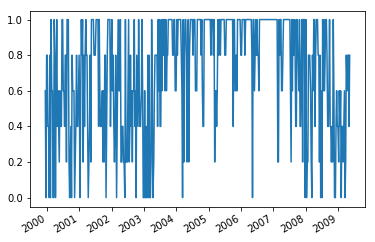

In [43]:
params['Accuracy'].plot()

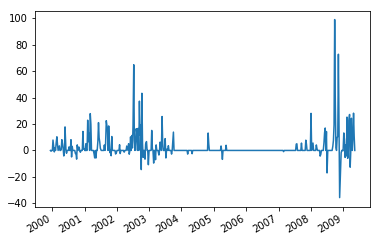

In [44]:
params['Sum of return'].plot()

### Feature importances

In [45]:
features = pd.DataFrame([d['features'] for d in test_params], index=indexes, columns=feature_names)

In [46]:
features.idxmax(axis=1).value_counts()

ADX 20               121
SMA (20, 40) diff     71
Std dev 20            56
Deviation EMA 40      40
ADX 14                36
ROC 30                22
RSI 20                20
SMA (10, 20) diff     18
Std dev 10            16
MACD (12, 16, 9)      12
MACD (14, 20, 12)     12
RSI 10                 8
CCI 14                 7
RSI 14                 6
ROC 10                 6
ROC 20                 6
MACD (3, 5, 2)         5
Deviation EMA 10       3
SMA (5, 10) diff       3
RSI 5                  2
ADX 7                  2
ROC 5                  1
Deviation EMA 20       1
dtype: int64

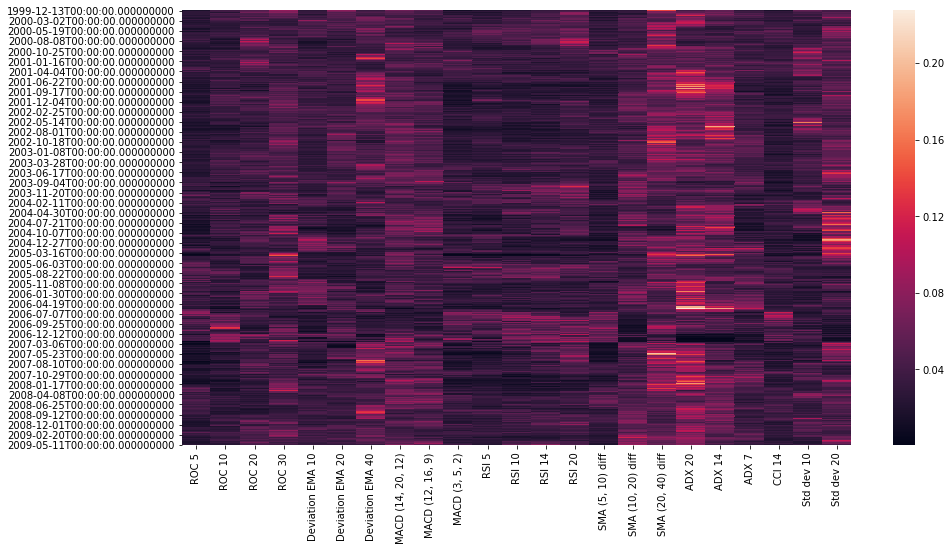

In [47]:
plt.figure(figsize=(15,8))
sns.heatmap(features)

C:\DEV\Anaconda3\envs\trading\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


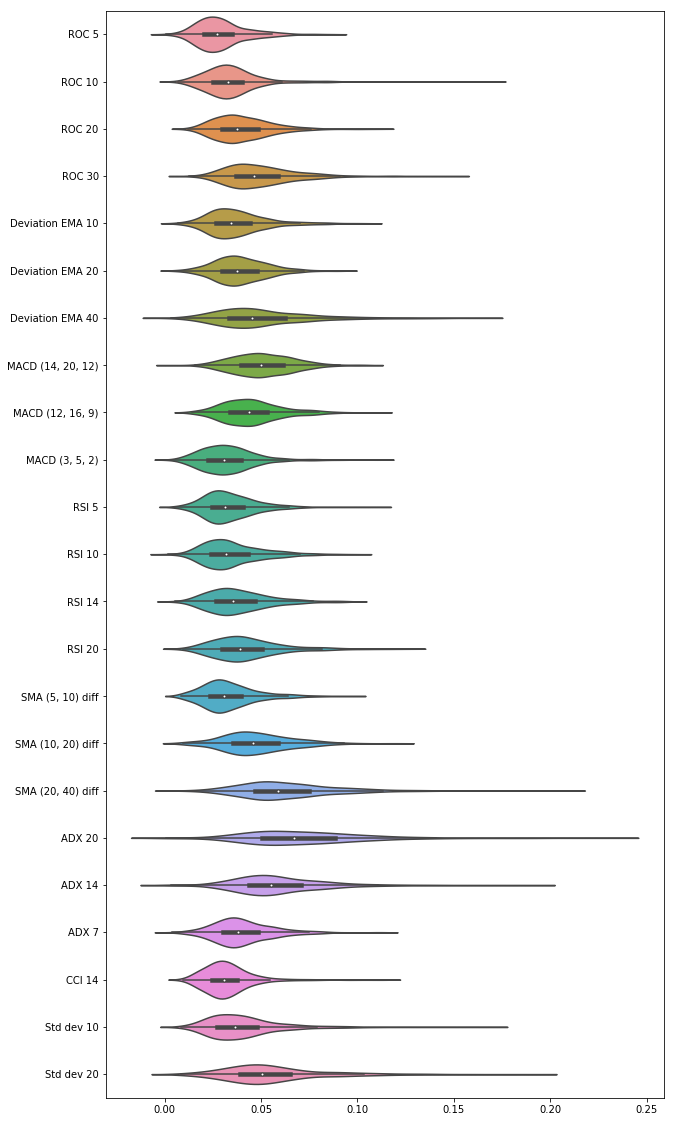

In [48]:
plt.figure(figsize=(10,20))
sns.violinplot(data=features, orient='h')